## 1. Importation des bibliothèques

In [2]:
# Manipulation de données
import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Modélisation
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.feature_selection import f_regression

import warnings
warnings.filterwarnings('ignore')

print("✅ Bibliothèques importées avec succès !")

✅ Bibliothèques importées avec succès !


## 2. Chargement des données

In [3]:
# Charger les données
df = pd.read_csv('datasets/original_cleaned_nyc_taxi_data_2018.csv')

print(f"📁 Dataset chargé : {df.shape[0]:,} lignes × {df.shape[1]} colonnes")
df.head()

📁 Dataset chargé : 8,319,928 lignes × 21 colonnes


,Unnamed: 0,trip_distance,rate_code,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,...,total_amount,pickup_location_id,dropoff_location_id,year,month,day,day_of_week,hour_of_day,trip_duration,calculated_total_amount
0,3,16.97,1,N,1,49.5,0.0,0.5,5.61,5.76,...,61.67,231,138,2018,3,29,3,13,3317.0,61.67
1,4,14.45,1,N,1,45.5,0.0,0.5,10.41,5.76,...,62.47,87,138,2018,3,29,3,14,3648.0,62.47
2,5,11.60,1,N,1,42.0,0.0,0.5,14.57,5.76,...,63.13,68,138,2018,3,29,3,14,3540.0,63.13
3,10,5.10,1,N,1,26.5,1.0,0.5,5.65,0.00,...,33.95,186,33,2018,3,29,3,16,2585.0,33.95
4,12,11.11,1,N,1,45.5,1.0,0.5,10.61,5.76,...,63.67,163,138,2018,3,29,3,16,4521.0,63.67


## 3. Préparation des données

### 3.1 Échantillonnage
Le dataset est très grand (8M+ lignes). On prend un échantillon pour accélérer l'entraînement.

In [4]:
# Échantillonnage pour accélérer (optionnel - à commenter si vous voulez tout le dataset)
SAMPLE_SIZE = 100000  # 100k lignes
df_sample = df.sample(n=SAMPLE_SIZE, random_state=42)

print(f"📊 Échantillon : {df_sample.shape[0]:,} lignes")

📊 Échantillon : 100,000 lignes


### 3.2 Nettoyage des données
Supprimons les valeurs aberrantes et les colonnes inutiles.

In [5]:
# Filtrer les valeurs aberrantes
df_clean = df_sample[
    (df_sample['fare_amount'] > 0) & 
    (df_sample['fare_amount'] < 200) &  # Exclure les tarifs extrêmes
    (df_sample['trip_distance'] > 0) & 
    (df_sample['trip_distance'] < 100) &  # Exclure les distances extrêmes
    (df_sample['trip_duration'] > 60) &  # Au moins 1 minute
    (df_sample['trip_duration'] < 7200)  # Max 2 heures
].copy()

print(f"📊 Après nettoyage : {df_clean.shape[0]:,} lignes")
print(f"❌ Lignes supprimées : {df_sample.shape[0] - df_clean.shape[0]:,}")

📊 Après nettoyage : 97,784 lignes
❌ Lignes supprimées : 2,216


### 3.3 Définition des variables

In [18]:
# Définir la variable cible y et les variables explicatives X
y = df_clean['fare_amount']

# Sélectionner les features les plus corrélées avec fare_amount
features = ['trip_distance', 'rate_code', 'payment_type', 'extra', 'mta_tax', 'tip_amount']

X = df_clean[features]

print(f"🎯 Variable cible : fare_amount")
print(f"📊 Features ({len(features)}) : {features}")
print(f"\nDimensions X : {X.shape}")
print(f"Dimensions y : {y.shape}")

🎯 Variable cible : fare_amount
📊 Features (6) : ['trip_distance', 'rate_code', 'payment_type', 'extra', 'mta_tax', 'tip_amount']

Dimensions X : (97784, 6)
Dimensions y : (97784,)


## 4. Analyse des corrélations

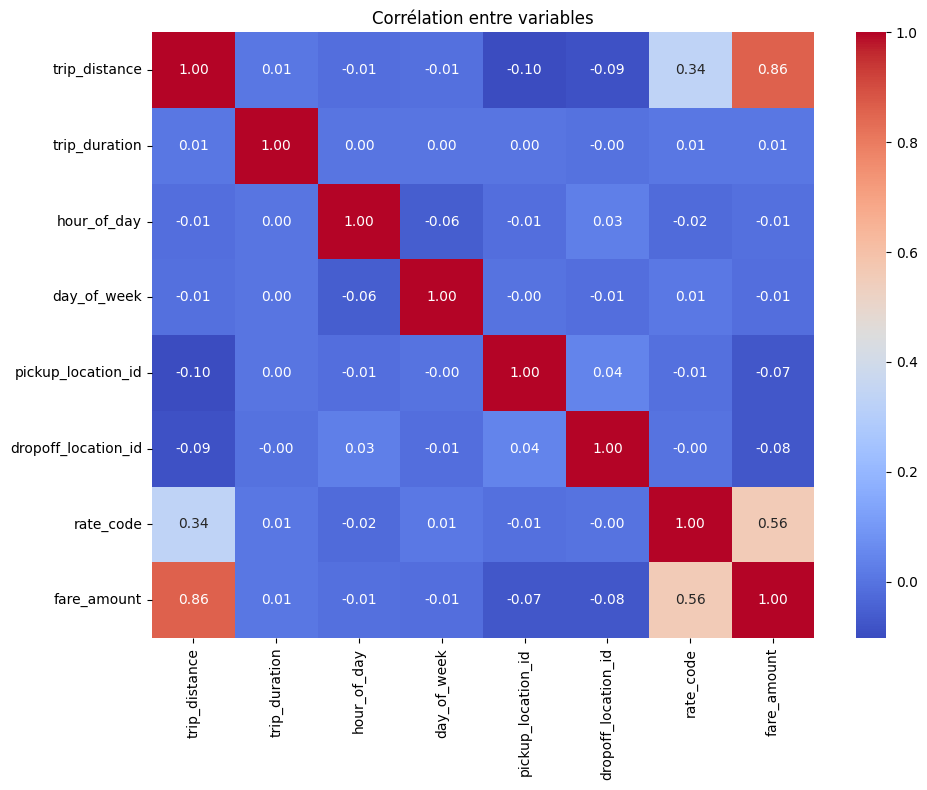

In [7]:
# Matrice de corrélation
plt.figure(figsize=(10, 8))
corr_data = pd.concat([X, y], axis=1)
sns.heatmap(corr_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Corrélation entre variables')
plt.tight_layout()
plt.show()

### 4.1 Matrice de corrélation COMPLÈTE (toutes les colonnes)
Voyons les corrélations avec TOUTES les variables pour identifier celles qui sont vraiment intéressantes.

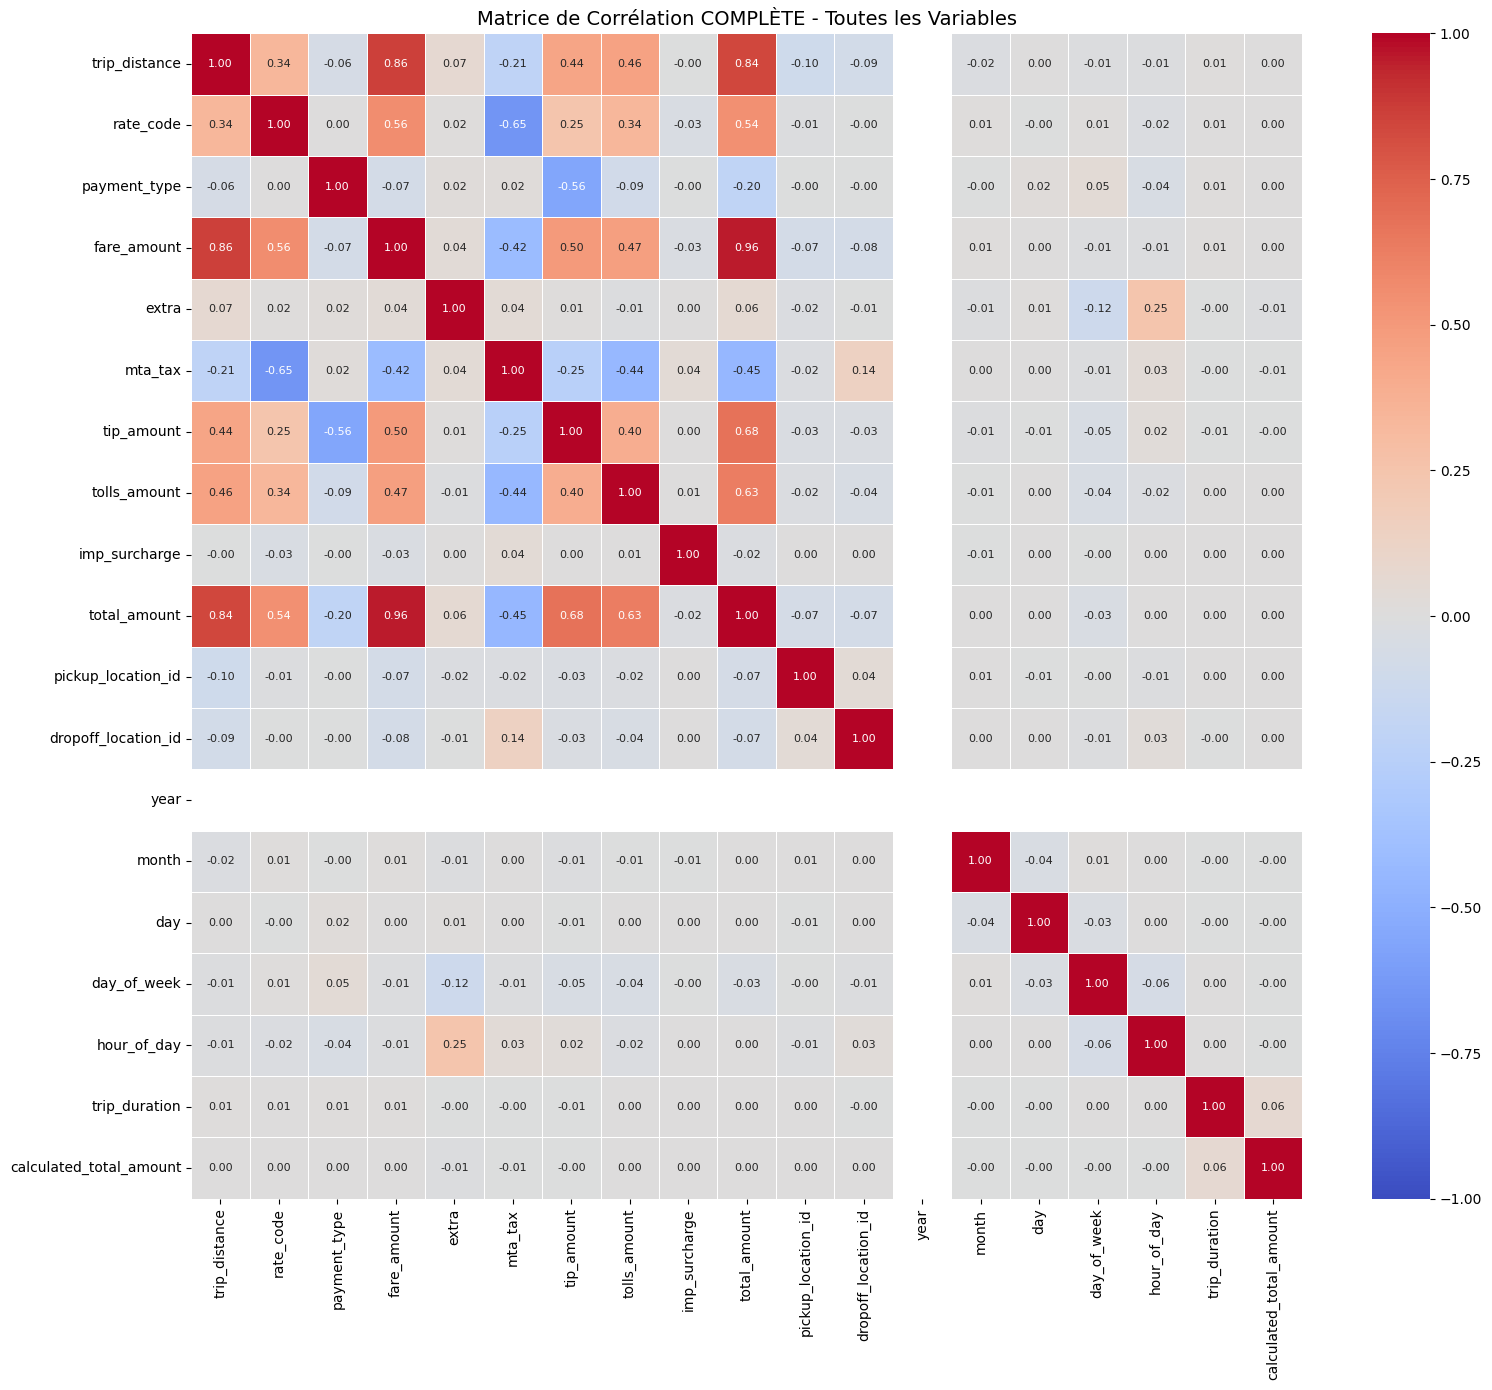


📊 CORRÉLATIONS AVEC fare_amount (triées par importance)
total_amount              : +0.9606  🔴 très forte
trip_distance             : +0.8597  🔴 très forte
rate_code                 : +0.5598  🟠 forte
tip_amount                : +0.4951  🟡 modérée
tolls_amount              : +0.4713  🟡 modérée
mta_tax                   : -0.4190  🟡 modérée
dropoff_location_id       : -0.0760  ⚪ faible
pickup_location_id        : -0.0747  ⚪ faible
payment_type              : -0.0724  ⚪ faible
extra                     : +0.0360  ⚪ faible
imp_surcharge             : -0.0257  ⚪ faible
day_of_week               : -0.0144  ⚪ faible
month                     : +0.0096  ⚪ faible
hour_of_day               : -0.0087  ⚪ faible
trip_duration             : +0.0080  ⚪ faible
calculated_total_amount   : +0.0024  ⚪ faible
day                       : +0.0024  ⚪ faible
year                      : +nan  ⚪ faible


In [17]:
# Matrice de corrélation COMPLÈTE avec toutes les colonnes numériques
all_numeric = df_clean.select_dtypes(include=[np.number])

# Exclure les colonnes inutiles
cols_to_exclude = ['Unnamed: 0']
all_numeric = all_numeric.drop(columns=[c for c in cols_to_exclude if c in all_numeric.columns])

plt.figure(figsize=(16, 14))
full_corr = all_numeric.corr()
sns.heatmap(full_corr, annot=True, cmap='coolwarm', fmt='.2f', 
            linewidths=0.5, vmin=-1, vmax=1, annot_kws={"size": 8})
plt.title('Matrice de Corrélation COMPLÈTE - Toutes les Variables', fontsize=14)
plt.tight_layout()
plt.show()

# Afficher les corrélations avec fare_amount triées
print("\n" + "="*60)
print("📊 CORRÉLATIONS AVEC fare_amount (triées par importance)")
print("="*60)
fare_corr = full_corr['fare_amount'].drop('fare_amount').sort_values(key=abs, ascending=False)
for var, corr in fare_corr.items():
    strength = "🔴 très forte" if abs(corr) >= 0.7 else "🟠 forte" if abs(corr) >= 0.5 else "🟡 modérée" if abs(corr) >= 0.3 else "⚪ faible"
    print(f"{var:25} : {corr:+.4f}  {strength}")

## 5. Test de significativité des variables (F-test)

In [8]:
# Calcul des statistiques F et des p-values
f_values, p_values = f_regression(X, y)

# Créer un tableau récapitulatif
pval_table = pd.DataFrame({
    'Variable': X.columns,
    'F_value': f_values,
    'P_value': p_values
})

# Formatage lisible
pval_table['F_value'] = pval_table['F_value'].map('{:.2f}'.format)
pval_table['P_value'] = pval_table['P_value'].apply(
    lambda x: f'{x:.2e}' if x < 0.01 else f'{x:.3f}'
)

# Trier par significativité
pval_table = pval_table.sort_values(by='P_value')

print("📊 Test de significativité des variables :")
print("=" * 50)
print(pval_table.to_string(index=False))
print("\n✅ Variables avec p-value < 0.05 sont statistiquement significatives")

📊 Test de significativité des variables :
           Variable   F_value   P_value
      trip_distance 277089.96  0.00e+00
          rate_code  44638.43  0.00e+00
      trip_duration      6.23     0.013
dropoff_location_id    568.70 2.46e-125
 pickup_location_id    548.59 5.51e-121
        hour_of_day      7.33  6.79e-03
        day_of_week     20.24  6.85e-06

✅ Variables avec p-value < 0.05 sont statistiquement significatives


## 6. Division Train/Test

In [19]:
# Division des données
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"📊 Ensemble d'entraînement : {X_train.shape[0]:,} lignes")
print(f"📊 Ensemble de test : {X_test.shape[0]:,} lignes")

📊 Ensemble d'entraînement : 78,227 lignes
📊 Ensemble de test : 19,557 lignes


## 7. Entraînement du modèle

In [20]:
# Créer et entraîner le modèle
model = LinearRegression()
model.fit(X_train, y_train)

print("✅ Modèle entraîné avec succès !")

✅ Modèle entraîné avec succès !


## 8. Prédictions

In [21]:
# Prédictions sur l'ensemble de test
y_pred = model.predict(X_test)

# Aperçu des prédictions vs valeurs réelles
comparison = pd.DataFrame({
    'Valeur réelle': y_test.values[:10],
    'Prédiction': y_pred[:10],
    'Erreur': abs(y_test.values[:10] - y_pred[:10])
})
print("📊 Aperçu des prédictions (10 premières) :")
print(comparison.round(2))

📊 Aperçu des prédictions (10 premières) :
   Valeur réelle  Prédiction  Erreur
0           23.5       27.24    3.74
1           22.5       24.63    2.13
2           31.5       35.85    4.35
3           25.0       24.57    0.43
4           61.0       60.19    0.81
5           24.5       24.23    0.27
6           52.0       53.47    1.47
7           22.0       19.33    2.67
8           31.5       33.18    1.68
9           37.0       41.90    4.90


## 9. Évaluation du modèle

In [22]:
# Calcul des métriques
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("=" * 50)
print("📈 MÉTRIQUES D'ÉVALUATION DU MODÈLE")
print("=" * 50)
print(f"\n🎯 R² Score : {r2:.4f} ({r2*100:.2f}% de variance expliquée)")
print(f"📉 RMSE : ${rmse:.2f}")
print(f"📉 MAE : ${mae:.2f}")
print("\n" + "=" * 50)

# Interprétation
if r2 > 0.8:
    print("✅ Excellent ! Le modèle explique très bien les données.")
elif r2 > 0.6:
    print("👍 Bon modèle. Performance acceptable.")
elif r2 > 0.4:
    print("⚠️ Modèle moyen. Peut être amélioré.")
else:
    print("❌ Modèle faible. Les variables ne suffisent pas à expliquer la cible.")

📈 MÉTRIQUES D'ÉVALUATION DU MODÈLE

🎯 R² Score : 0.8316 (83.16% de variance expliquée)
📉 RMSE : $5.96
📉 MAE : $3.64

✅ Excellent ! Le modèle explique très bien les données.


## 10. Visualisation des résultats

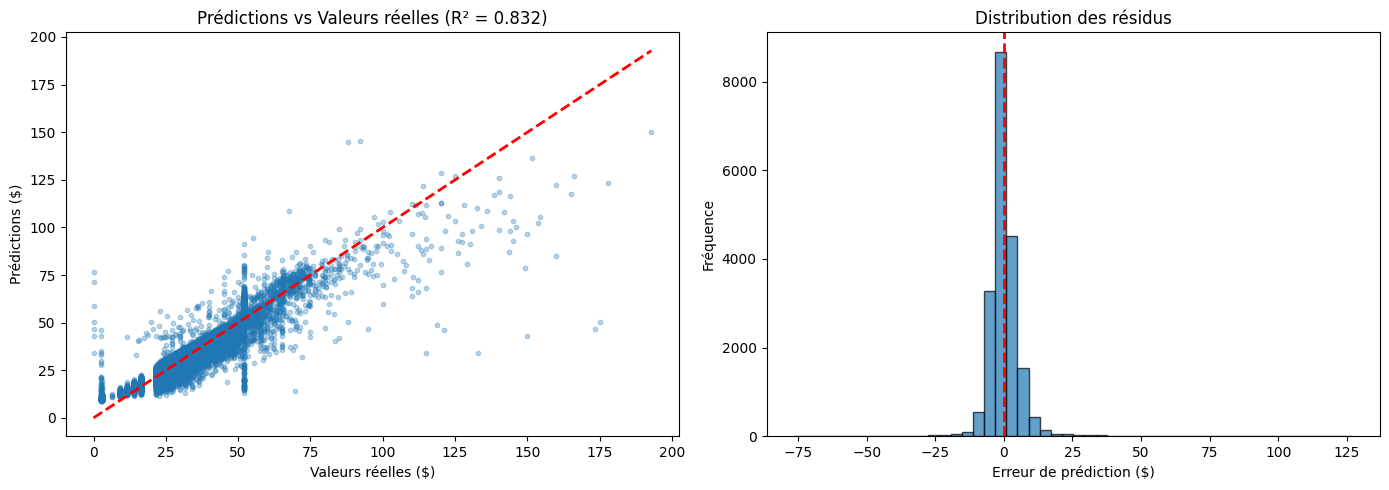

In [23]:
# Visualisation Prédictions vs Valeurs réelles
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
axes[0].scatter(y_test, y_pred, alpha=0.3, s=10)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Valeurs réelles ($)')
axes[0].set_ylabel('Prédictions ($)')
axes[0].set_title(f'Prédictions vs Valeurs réelles (R² = {r2:.3f})')

# Distribution des erreurs
residuals = y_test - y_pred
axes[1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Erreur de prédiction ($)')
axes[1].set_ylabel('Fréquence')
axes[1].set_title('Distribution des résidus')

plt.tight_layout()
plt.show()

## 11. Formule de la régression linéaire

In [24]:
# Récupérer l'intercept et les coefficients
intercept = model.intercept_
coefficients = model.coef_

# Afficher les coefficients
print("📊 Coefficients du modèle :")
print("=" * 50)
print(f"Intercept (β₀) : {intercept:.4f}")
print("\nCoefficients :")
for var, coef in zip(X.columns, coefficients):
    print(f"  {var}: {coef:.4f}")

# Générer la formule
print("\n" + "=" * 50)
print("📐 FORMULE DE LA RÉGRESSION LINÉAIRE :")
print("=" * 50)
formula = f"fare_amount = {intercept:.2f}"
for var, coef in zip(X.columns, coefficients):
    sign = '+' if coef >= 0 else '-'
    formula += f" {sign} {abs(coef):.4f}×{var}"

print(formula)

📊 Coefficients du modèle :
Intercept (β₀) : 10.8326

Coefficients :
  trip_distance: 2.0944
  rate_code: 5.6139
  payment_type: 1.3566
  extra: -0.3994
  mta_tax: -17.4233
  tip_amount: 0.4131

📐 FORMULE DE LA RÉGRESSION LINÉAIRE :
fare_amount = 10.83 + 2.0944×trip_distance + 5.6139×rate_code + 1.3566×payment_type - 0.3994×extra - 17.4233×mta_tax + 0.4131×tip_amount


## 12. Importance des variables

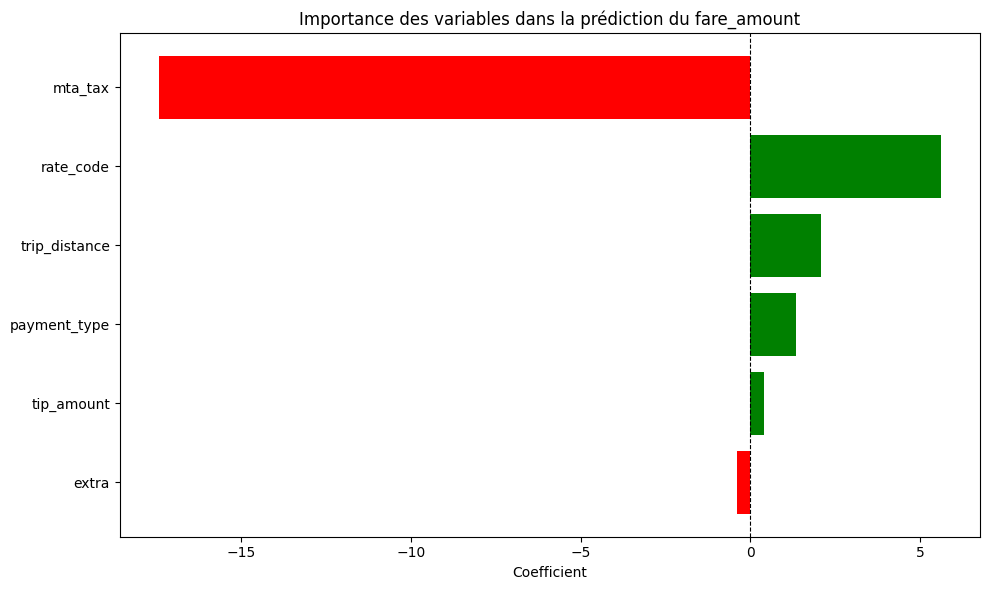


🔹 Vert = Impact positif sur le tarif
🔹 Rouge = Impact négatif sur le tarif


In [25]:
# Importance des variables (basée sur les coefficients normalisés)
importance = pd.DataFrame({
    'Variable': X.columns,
    'Coefficient': coefficients,
    'Importance': np.abs(coefficients)
}).sort_values('Importance', ascending=True)

plt.figure(figsize=(10, 6))
colors = ['green' if c > 0 else 'red' for c in importance['Coefficient']]
plt.barh(importance['Variable'], importance['Coefficient'], color=colors)
plt.xlabel('Coefficient')
plt.title('Importance des variables dans la prédiction du fare_amount')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.show()

print("\n🔹 Vert = Impact positif sur le tarif")
print("🔹 Rouge = Impact négatif sur le tarif")

## 13. Sauvegarde du modèle (optionnel)

In [ ]:
# Sauvegarde avec joblib (sklearn)
import joblib

joblib.dump(model, 'fare_prediction_model.pkl')
print("✅ Modèle sauvegardé : fare_prediction_model.pkl")

## 14. Résumé final

In [26]:
print("=" * 60)
print("📋 RÉSUMÉ DU MODÈLE DE PRÉDICTION - NYC TAXI FARE")
print("=" * 60)

print(f"\n🎯 Variable cible : fare_amount")
print(f"\n📊 Features utilisées ({len(features)}) :")
for f in features:
    print(f"   • {f}")

print(f"\n📈 PERFORMANCES :")
print(f"   • R² Score : {r2:.4f} ({r2*100:.2f}%)")
print(f"   • RMSE : ${rmse:.2f}")
print(f"   • MAE : ${mae:.2f}")

print(f"\n📊 DONNÉES :")
print(f"   • Échantillon total : {len(df_clean):,} lignes")
print(f"   • Entraînement : {len(X_train):,} lignes")
print(f"   • Test : {len(X_test):,} lignes")

print("\n" + "=" * 60)

📋 RÉSUMÉ DU MODÈLE DE PRÉDICTION - NYC TAXI FARE

🎯 Variable cible : fare_amount

📊 Features utilisées (6) :
   • trip_distance
   • rate_code
   • payment_type
   • extra
   • mta_tax
   • tip_amount

📈 PERFORMANCES :
   • R² Score : 0.8316 (83.16%)
   • RMSE : $5.96
   • MAE : $3.64

📊 DONNÉES :
   • Échantillon total : 97,784 lignes
   • Entraînement : 78,227 lignes
   • Test : 19,557 lignes

